<a href="https://colab.research.google.com/github/riasonalker1906/aging-farmer-demographic-productivity/blob/main/County_age_productivity_trends.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --quiet gcsfs google-cloud-storage

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 1.9 MB/s eta 0:00:00


**Authenticating access to Google Cloud Services**



In [ ]:
## Authenticate your Google account to access Google Cloud services. This will allow you to interact with Google Cloud Storage using the credentials associated with your account.
## Also import your Google Drive to access your team's Shared Google Drive as well as Operating System
%%capture
from google.colab import auth
from google.colab import drive
import os
auth.authenticate_user()
#drive.mount('/content/drive', force_remount=True)

## If your team is using a Shared Drive in a Google Workspace
#directory_path = '/content/drive/Shared drives/YOUR_SHARED_DRIVE_NAME/'

## if your team is using a Shared Folder in a non-Google Workspace
#directory_path = '/content/drive/MyDrive/YOUR_SHARED_FOLDER_NAME/'


In [ ]:
## Initialize the Google Cloud Storage client.
from google.cloud import storage
client = storage.Client(project='HDSI-Agri-Datathon-2024')

In [ ]:
# Define the folder path in the bucket (e.g., 'your_folder_name/')
%%capture
folder_path = 'HDSI_AGRI_Prompt_2/'


# List blobs that are within the specified folder
blobs_in_folder = list(bucket.list_blobs(prefix=folder_path))

# Initialize variable to count the files in the folder
file_count = 0

# List all files in the specified folder
for blob in blobs_in_folder:
    # Exclude subfolders and only list files
    if not blob.name.endswith('/'):
        file_count += 1


NameError: name 'bucket' is not defined

In [ ]:
# Mount Google Drive
%%capture
from google.colab import drive
drive.mount('/content/drive')

# Define the folder path in the bucket (e.g., 'HDSI_AGRI_Prompt_3/')
folder_path = 'HDSI_AGRI_Prompt_2/'

# Google Drive directory where you want to download the files
drive_directory = '/content/drive/MyDrive/HDSI_personal/'

# Create the directory in Google Drive if it doesn't exist
import os
if not os.path.exists(drive_directory):
    os.makedirs(drive_directory)

# List blobs that are within the specified folder
blobs_in_folder = list(bucket.list_blobs(prefix=folder_path))

# Initialize variable to count the files in the folder
file_count = 0

# List all files in the specified folder and download them to Google Drive
for blob in blobs_in_folder:
    # Exclude subfolders and only list files
    if not blob.name.endswith('/'):
        file_count += 1

        # Download the file to Google Drive
        local_file_path = os.path.join(drive_directory, os.path.basename(blob.name))
        blob.download_to_filename(local_file_path)



NameError: name 'bucket' is not defined

In [ ]:
%%capture
import pandas as pd
from google.cloud import storage
import io


# Initialize the Google Cloud Storage client.
client = storage.Client(project='HDSI-Agri-Datathon-2024')

bucket_name = 'hdsi-agri-prompt-data'
blob_name = 'HDSI_AGRI_Prompt_2/sales_data_county.csv'

# Access the specified bucket and blob
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)

# Download the blob's content as bytes
content = blob.download_as_bytes()

# Load the CSV data from the downloaded content using io.BytesIO
sales_totals_county = pd.read_csv(io.BytesIO(content))

**Data Cleaning: Removing Missing Values**

In [ ]:
# Setting a threshold for missing values (e.g., 50%)
threshold = 0.50

# Calculate the percentage of missing values in each column
missing_percent = sales_totals_county.isna().mean()

# Find columns where the percentage of missing values exceeds the threshold
cols_to_drop = missing_percent[missing_percent > threshold].index

# Drop those columns
sales_totals_county_cleaned = sales_totals_county.drop(columns=cols_to_drop)

In [ ]:
# Drop rows with NaN values
sales_totals_county_cleaned = sales_totals_county_cleaned.dropna()

# Drop rows where any cell contains the value '(D)'
sales_totals_county_cleaned = sales_totals_county_cleaned[~sales_totals_county_cleaned.isin(['(D)']).any(axis=1)]

In [ ]:
# Remove rows where the 'County_Code' column contains the value 999 #
sales_totals_county_cleaned = sales_totals_county_cleaned[sales_totals_county_cleaned['COUNTY_CODE'] != 999]

**Categorizing Sales and Operations with Sales columns for Calculation purposes**

In [ ]:
# Find the sales columns
sales_columns = sales_totals_county_cleaned.filter(like='_SALES_MEASURED_IN_DOLLARS').columns

# Find the operation of sales columns
ops_columns = sales_totals_county_cleaned.filter(like='_OPERATIONS_WITH_SALES').columns


**Combining State and County FIP codes**

In [ ]:
# Assuming raw_df contains the original DataFrame
sales_totals_county_cleaned['STATE_FIPS_CODE'] = sales_totals_county['STATE_FIPS_CODE'].apply(lambda x: str(x).zfill(2))
sales_totals_county_cleaned['COUNTY_CODE'] = sales_totals_county['COUNTY_CODE'].apply(lambda x: str(x).zfill(3))

# Concatenate the state and county FIPS codes
sales_totals_county_cleaned['County FIP'] = sales_totals_county_cleaned['STATE_FIPS_CODE'] + sales_totals_county_cleaned['COUNTY_CODE']

**Measuring Economic Productivity**

In [ ]:

import numpy as np
import pandas as pd

# Function to clean and convert columns to float
def clean_and_convert_to_float(df, columns):
    for column in columns:
        # Convert to string first if necessary
        df[column] = df[column].astype(str).str.replace(',', '')  # Remove commas
        df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert to numeric
    return df

# Set the desired type for ops_columns and sales_columns
sales_totals_county_cleaned = clean_and_convert_to_float(sales_totals_county_cleaned, ops_columns)
sales_totals_county_cleaned = clean_and_convert_to_float(sales_totals_county_cleaned, sales_columns)

# Create new columns for total sales and total quantity sold
sales_totals_county_cleaned['Total_Sales'] = sales_totals_county_cleaned[sales_columns].sum(axis=1)
sales_totals_county_cleaned['Number_of_Operations'] = sales_totals_county_cleaned[ops_columns].sum(axis=1)


# Calculate Average Sales per Operation
sales_totals_county_cleaned['Average_Sales_per_Operation'] = (
    sales_totals_county_cleaned['Total_Sales'] / sales_totals_county_cleaned['Number_of_Operations']
)



**Merging Cleaned Data frames**

In [ ]:
%%capture

from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Load the CSV files from the shared drive
sales_df = sales_totals_county_cleaned
age_df = pd.read_csv('/content/drive/MyDrive/Harvard Datathon 2024/county_age_data_no999.csv')

# Ensure 'County FIP' is string in both DataFrames
age_df['County FIP'] = age_df['County FIP'].astype(str)
sales_df['County FIP'] = sales_df['County FIP'].astype(str)

# Merge the two DataFrames on 'year' and 'County FIP'
merged_df = pd.merge(age_df, sales_df[['YEAR', 'County FIP', 'Average_Sales_per_Operation']], on=['YEAR','County FIP'])

# Optionally, save the merged DataFrame to a new CSV file in the shared drive
merged_df.to_csv('/content/drive/MyDrive/Harvard Datathon 2024/merged_county_data.csv', index=False)



**Categorizing Top 25% and Bottom 25% counties based on Average Sales per Operation**

In [ ]:

import pandas as pd

# Sort DataFrame by 'Average_Sales_per_Operation' in descending order (highest to lowest)
sorted_df = merged_df.sort_values(by='Average_Sales_per_Operation', ascending=False)

# Calculate the threshold for the top 5%, 10%, and 25% most productive counties
top_25_percent_threshold = sorted_df['Average_Sales_per_Operation'].quantile(0.75)

# Filter the top 5%, 10%, and 25% most productive counties
top_25_percent = sorted_df[sorted_df['Average_Sales_per_Operation'] >= top_25_percent_threshold]

# Calculate the threshold for the bottom 5%, 10%, and 25% least productive counties
bottom_25_percent_threshold = sorted_df['Average_Sales_per_Operation'].quantile(0.25)

# Filter the bottom 5%, 10%, and 25% least productive counties
bottom_25_percent = sorted_df[sorted_df['Average_Sales_per_Operation'] <= bottom_25_percent_threshold]

**Verifying Data Types of columns to be used in Modelling**

In [ ]:
%%capture
top_25_percent['Avg_Age'] = pd.to_numeric(top_25_percent['Avg_Age'], errors='coerce')
bottom_25_percent['Avg_Age'] = pd.to_numeric(bottom_25_percent['Avg_Age'], errors='coerce')

**Implementing the Model: Polynomial Regression**

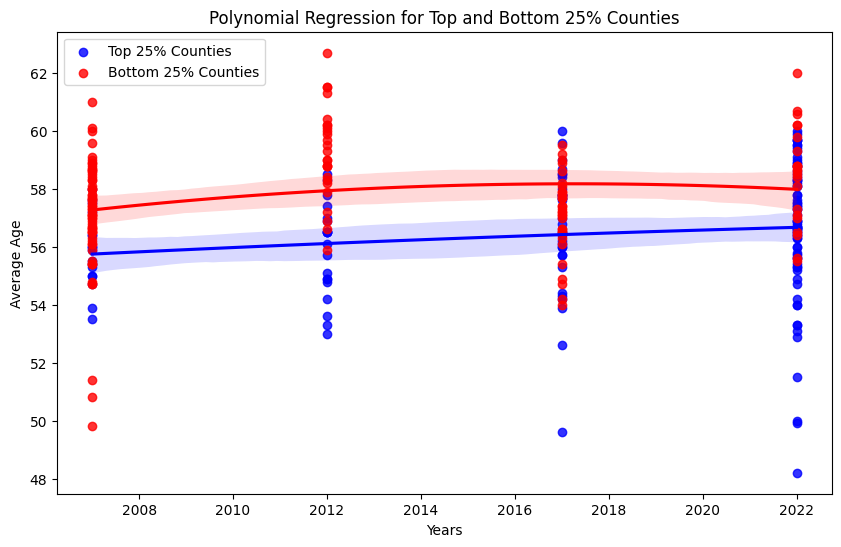

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_top = top_25_percent[['YEAR']]
y_top = top_25_percent['Avg_Age']
X_bottom = bottom_25_percent[['YEAR']]
y_bottom = bottom_25_percent['Avg_Age']

X_top_train, X_top_test, y_top_train, y_top_test = train_test_split(X_top, y_top, test_size=0.2, random_state=42)
X_bottom_train, X_bottom_test, y_bottom_train, y_bottom_test = train_test_split(X_bottom, y_bottom, test_size=0.2, random_state=42)

# Polynomial transformation (degree 2, can be changed)
poly = PolynomialFeatures(degree=2)

# Transform the features for both top and bottom counties
X_top_train_poly = poly.fit_transform(X_top_train)
X_bottom_train_poly = poly.fit_transform(X_bottom_train)

# Fit the model (using linear regression on polynomial features)
model_top = LinearRegression().fit(X_top_train_poly, y_top_train)
model_bottom = LinearRegression().fit(X_bottom_train_poly, y_bottom_train)

# Predict on the testing data
X_top_test_poly = poly.transform(X_top_test)
X_bottom_test_poly = poly.transform(X_bottom_test)

y_top_pred = model_top.predict(X_top_test_poly)
y_bottom_pred = model_bottom.predict(X_bottom_test_poly)

# Calculate mean squared error to evaluate performance
mse_top = mean_squared_error(y_top_test, y_top_pred)
mse_bottom = mean_squared_error(y_bottom_test, y_bottom_pred)

# Get the slopes (coefficients)
slope_top = model_top.coef_[0]
slope_bottom = model_bottom.coef_[0]

# Plot the training data with regression lines
fig, ax = plt.subplots(figsize=(10, 6))

sns.regplot(x=X_top_train['YEAR'], y=y_top_train, ax=ax,
            label='Top 25% Counties', scatter_kws={'color': 'blue'},
            line_kws={'color': 'blue'}, order=2)

sns.regplot(x=X_bottom_train['YEAR'], y=y_bottom_train, ax=ax,
            label='Bottom 25% Counties', scatter_kws={'color': 'red'},
            line_kws={'color': 'red'}, order=2)

ax.set_xlabel('Years')
ax.set_ylabel('Average Age')
ax.set_title('Polynomial Regression for Top and Bottom 25% Counties')

ax.legend()
plt.show()

# Fit using statsmodels for summary statistics (example for top counties)
X_top_train_sm = sm.add_constant(X_top_train_poly)  # Add a constant term
model_top_sm = sm.OLS(y_top_train, X_top_train_sm).fit()